Train with just koopman matrix and then adding sequence model later


In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
torch.cuda.empty_cache()
exp_dir   = "Trained_Models/Test_2DCyl_NewData"
# pickle.load(open("Trained_Models/Cluster_Models/Exp4.2.4_Transient_2DCyl_MULTISTEP_numobstest_with_seqmodel_switch/sl33_nhu40_numobs3_bs16_lr5e-5_ph10/args"))
models = []


exp_name_list = [
                  "sl64_nhu40_numobs2_bs16_lr5e-5"
                
                 ]
for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))
models
# eval_mza = Eval_MZA(exp_dir, exp_name)

sl64_nhu40_numobs2_bs16_lr5e-5


In [4]:
models[0].deactivate_seqmodel

False

Epoch with Minimum train_error:  128


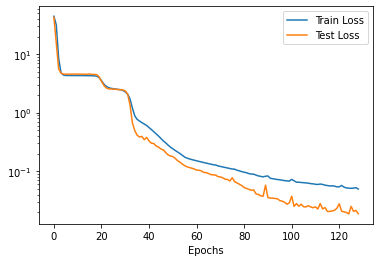

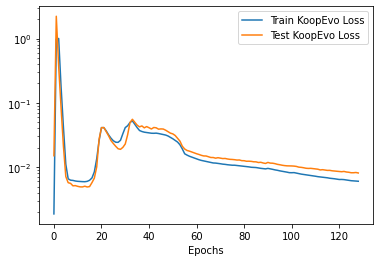

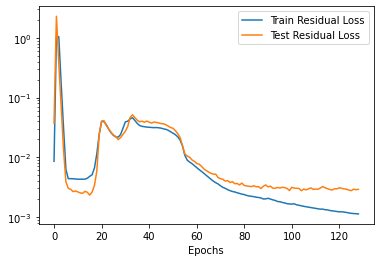

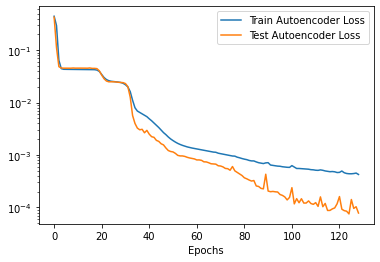

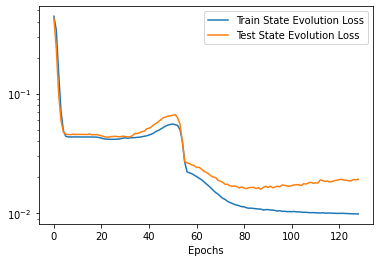

In [5]:
#Sort Models
# def param_find(model):
#     return model.seq_len
# models.sort(key = param_find)

# for model in models:
#     print(model.exp_name)

#plot learning curves
models[0].plot_learning_curves()

In [6]:
#loading weights
# epoch_num = 1700

# #Non Transient data
# for i in range(len(models)):
#     if i==0:
#         epoch_num = 8059
#     elif i == 1:
#         epoch_num = 4999
#     elif i == 7:
#         epoch_num = 2990
#     else:
#         epoch_num = 2990
#     models[i].load_weights(epoch_num)

# # Transient Data with numobs3 and 5
# for i in range(0,len(models)):
#     if i == 0:
#         epoch_num = 4150
#     elif i == 1:
#         epoch_num = 3075
#     elif i == 2:
#         epoch_num = 4000  
#     elif i == 3:
#         epoch_num = 3000
#     elif i == 4:
#         epoch_num = 4600
#     models[i].load_weights(epoch_num)

# Transient Data with numobs5 only
for i in range(0,len(models)):
    epoch_num = 7999
    models[i].load_weights(epoch_num, True)

In [7]:
# for i in range(0,len(models)):

ph0 = models[0].pred_horizon 
models[0].pred_horizon = 1


In [8]:
#One Step Prediction
model_num = 0
# models[model_num].data_dir = models[-2].data_dir
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Train")
dataset = models[model_num].train_dataset
num_trajs = models[model_num].train_num_trajs

# eval_mza.train_size = 0.9
for i in range(1):#len(models)):
    i=model_num
    # del eval_mza.lp_data 
    # torch.cuda.empty_cache()
    # del eval_mza.train_dataset
    # del eval_mza.train_dataloader
    if not models[i].deactivate_seqmodel:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE, koop_out, seqmodel_out = models[i].predict_onestep(dataset, num_trajs)
    else:
        x_nn_hat, Phi_nn_hat, x_nn, Phi_nn, State_MSE = models[i].predict_onestep(dataset, num_trajs)
    print(x_nn_hat.shape, Phi_nn_hat.shape, Phi_nn.shape)

    #Plotting one step prediction
    x_nn_hat.shape

models[0].pred_horizon = ph0


Data Shape:  (1, 882, 7738)
Not normalizing Input
Train_Shape:  (1, 793, 7738)
Time:  0.3812906742095947


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([1, 792, 2]) torch.Size([1, 792, 7738]) torch.Size([1, 792, 7738])


In [9]:
#Load Data
with open('Data/2DCylinder/processed_data/pklfiles/nektar_cyl_data_40_dt0.25_T1000.pkl', 'rb') as f:
    data_dict = pickle.load(f)


In [10]:
sub_X = data_dict["sub_X"]
sub_Y = data_dict["sub_Y"]
U_nn = Phi_nn_hat[...,:int(Phi_nn_hat.shape[-1]/2)].detach().cpu().numpy()
V_nn = Phi_nn_hat[...,int(Phi_nn_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_nn.shape, V_nn.shape, U.shape, V.shape


((1, 792, 3869), (1, 792, 3869), (1, 792, 3869), (1, 792, 3869))

In [11]:
def energy(u,v):
    k = 0.5*(np.mean(u**2,axis=-1) + np.mean(v**2,axis=-1))
    return k

k_pred = energy(U_nn,V_nn)
k = energy(U, V)

(1, 792)


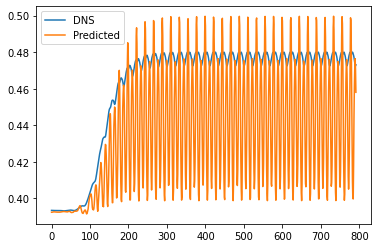

In [12]:
print(k.shape)
plt.plot(k[0,:], label = "DNS")
plt.plot(k_pred[0,:], label = "Predicted")
plt.legend()

In [ ]:
for i in range(100,150):
    plt.figure()
    plt.scatter(sub_X,sub_Y,c=abs((U_nn[0,i]-U[0,i])/U[0,i]), s=1, cmap = 'coolwarm')
    cbar = plt.colorbar()
    # Set the colorbar limits
    cbar.mappable.set_clim(vmin=0, vmax=0.1)
    plt.gca().set_aspect('equal')

    # plt.savefig(models[-3].exp_dir + "/" + models[-3].exp_name + "/error_pred/")

# plt.axes().set_aspect('equal')

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,0], label = "Predicted")
    plt.plot(Phi_nn.cpu().numpy()[i,:,0], label = "DNS")
    plt.legend()

plt.ylabel("u0")
plt.xlabel("Timesteps")
plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

In [ ]:
for i in range (1):
    plt.figure()
    plt.plot(koop_out.cpu().numpy()[i,:,1], label = "Koopman Predicted")
    plt.plot(seqmodel_out.cpu().numpy()[i,:,1], label = "Seqmodel Predicted")
    plt.plot(Phi_nn_hat.cpu().numpy()[i,:,1], label = "DNS")
    plt.legend()

plt.figure()
plt.semilogy(State_MSE.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("MSE")
plt.legend()

Multi Step prediction

In [131]:
for i in [0,1,2,3,4,5,6,7]:
    models[i].deactivate_seqmodel = False

In [14]:
#multistep prediction
timesteps = 600
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i], Phi_ms_koop[i], xkoop_hat_temp, xseq_hat_temp = models[i].predict_multistep(initial_conditions, timesteps)
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape, Phi_ms_koop.shape)


ic shape: torch.Size([1, 7738])
torch.Size([1, 1, 601, 7738]) torch.Size([1, 1, 600, 7738])


In [15]:
U_ms_hat = Phi_ms_hat[...,:int(Phi_ms_hat.shape[-1]/2)].detach().cpu().numpy()
V_ms_hat = Phi_ms_hat[...,int(Phi_ms_hat.shape[-1]/2):].detach().cpu().numpy()
U = Phi_nn[...,:int(Phi_nn.shape[-1]/2)].detach().cpu().numpy()
V = Phi_nn[...,int(Phi_nn.shape[-1]/2):].detach().cpu().numpy()

U_ms_hat.shape, V_ms_hat.shape, U.shape, V.shape

((1, 1, 601, 3869), (1, 1, 601, 3869), (1, 792, 3869), (1, 792, 3869))

(1, 1, 601)


IndexError: index 1 is out of bounds for axis 0 with size 1

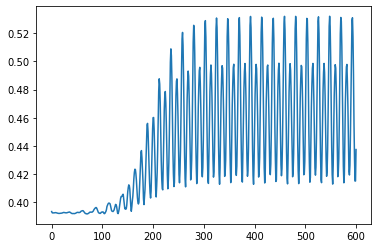

In [16]:
#calculating kinetic energy for multistep prediction
k_ms_pred = energy(U_ms_hat, V_ms_hat)
print(k_ms_pred.shape)
plt.figure()
for i in [0,1,2,3,4,5,6]:
    
    plt.plot(k_ms_pred[i,0,:], label = f"Memory Length {models[i].seq_len-1}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("Kinetic Energy")

In [28]:
U_ms_koop = Phi_ms_koop[...,:int(Phi_ms_koop.shape[-1]/2)].detach().cpu().numpy()
V_ms_koop = Phi_ms_koop[...,int(Phi_ms_koop.shape[-1]/2):].detach().cpu().numpy()

U_ms_koop.shape, V_ms_koop.shape

((8, 1, 1000, 3969), (8, 1, 1000, 3969))

(8, 1, 600)


Text(0, 0.5, 'kinetic energy')

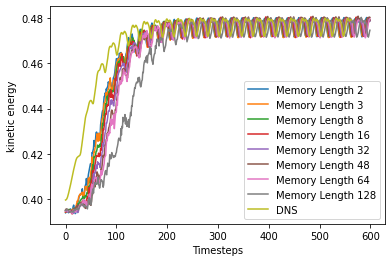

In [162]:
#calculating kinetic energy for multistep prediction
k_ms_koop = energy(U_ms_koop, V_ms_koop)
print(k_ms_koop.shape)
plt.figure()
for i in [0,1,2,3,4,5,6,7]:
    
    plt.plot(k_ms_koop[i,0,:], label = f"Memory Length {models[i].seq_len-1}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")
# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.plot(k[0,initial_step:], label = "DNS")

plt.legend(loc='lower right')
plt.xlabel("Timesteps")
plt.ylabel("kinetic energy")

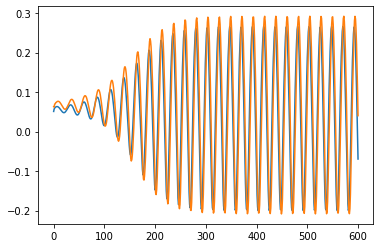

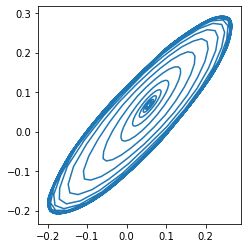

In [17]:
#plotting mode evolution
plt.figure()

model_num = 0
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(x_ms_hat[model_num][0,:,n].cpu().numpy(), label = f"Mode {n}")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(x_ms_hat[model_num][0,:,0].cpu().numpy(), x_ms_hat[model_num][0,:,1].cpu().numpy())

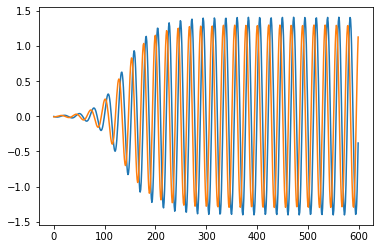

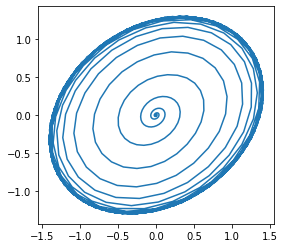

In [22]:
#plotting mode evolution
plt.figure()
model_num = 4
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(xkoop_ms_hat[model_num][0,:,n].cpu().numpy(), label = f"Mode {n}")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xkoop_ms_hat[model_num][0,:,0].cpu().numpy(), xkoop_ms_hat[model_num][0,:,1].cpu().numpy())

Text(0, 0.5, 'Observables $  L_{2} Norm$')

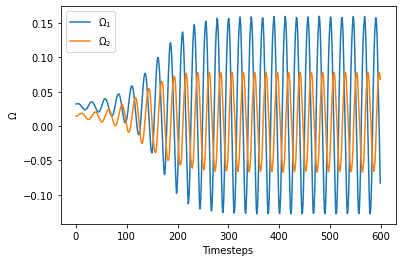

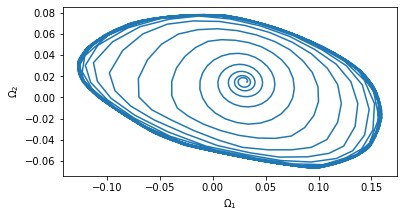

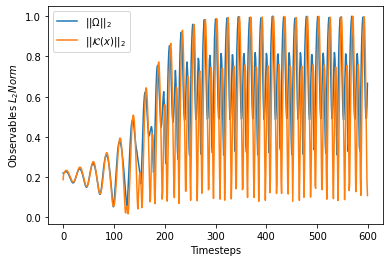

In [19]:
#plotting mode evolution
plt.figure()
model_num = 0
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()
for n in [0,1]:#range(models[model_num].num_obs):
    plt.plot(xseq_ms_hat[model_num][0,:,n].cpu().numpy(), label = r"$\Omega$"+f"$_{n+1}$")

plt.legend()
plt.xlabel("Timesteps")
plt.ylabel(r"$\Omega$")

plt.figure()
plt.gca().set_aspect('equal')
plt.plot(xseq_ms_hat[model_num][0,:,0].cpu().numpy(), xseq_ms_hat[model_num][0,:,1].cpu().numpy())
plt.xlabel(f"$\Omega_{1}$")
plt.ylabel(f"$\Omega_{2}$")

plt.figure()
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)

plt.plot((tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:], label = r"$||\Omega||_{2}$")
plt.plot((tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:], label = r"$||\mathcal{K}(x)||_{2}$")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("Observables " + r"$  L_{2} Norm$")

In [ ]:
#plotting error contours for flowfield
for i in range (300,400,5):
    plt.figure()
    # plt.scatter(sub_X,sub_Y,c=abs((U_ms_hat[-2,0,i]-U[0,i])/U[0,i]), s=1, cmap = 'coolwarm')
    plt.scatter(sub_X,sub_Y,c = U_ms_hat[-1,0,i], s=1, cmap = 'coolwarm')
    cbar = plt.colorbar()
    # Set the colorbar limits
    # cbar.mappable.set_clim(vmin=0, vmax=0.1)
    plt.gca().set_aspect('equal')

    # plt.savefig(models[-1].exp_dir + "/" + models[-1].exp_name + "/out_log/error_plots/fig"+str(i)+".png")

torch.Size([1, 663, 7938]) torch.Size([8, 1, 601, 7938])


Text(0, 0.5, 'MSE')

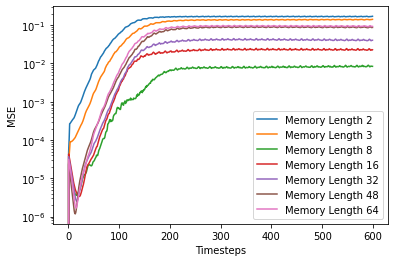

In [48]:
print(Phi_nn.shape, Phi_ms_hat.shape)
State_MSE_multistep = torch.zeros((len(models),timesteps))

plt.figure()
for i in [0,1,2,3,4,5,6]:#range(len(models)-3):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    # if i!=len(models)-1:
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Memory Length {models[i].seq_len-1}")
    # else:
    #     plt.semilogy(State_MSE_multistep[len(models)-1].numpy(),".-",color = "brown", label = f"No Memory")

# State_MSE_multistep[1] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[1,:,:timesteps]).detach().cpu()
# plt.semilogy(State_MSE_multistep[1].numpy(), label = f"Memory Length {models[1].seq_len}")
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")
# np.save("koopman_numobs32.npy",Phi_hat.cpu().numpy())

In [ ]:
plt.figure()
for i in range(len(models)):
    State_MSE_multistep[i] = Eval_MZA.state_mse(Phi_nn[:,:timesteps],Phi_ms_hat[i,:,:timesteps]).detach().cpu()
    plt.semilogy(State_MSE_multistep[i].numpy(), label = f"Number of Observables {models[i].num_obs}")

plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("MSE")

In [ ]:
#multistep prediction
timesteps_jac = 200
initial_step = 0
initial_conditions = Phi_nn[:,initial_step,:].to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat = torch.zeros((len(models),1,timesteps_jac+1,models[0].statedim)).to(models[0].device)
Phi_ms_koop = torch.zeros((len(models),1,timesteps_jac,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

grad_xn_xseq = []

for i in [0,1,2,3]:#range(len(models)):
    
    grad_xn_xseq.append(models[i].jacobian_calc(initial_conditions, timesteps_jac))
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)

print(grad_xn_xseq[0].shape)

ic shape: torch.Size([1, 512])


d:\Anaconda\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


0 torch.Size([1, 48])
1 torch.Size([1, 48])
2 torch.Size([1, 48])
3 torch.Size([1, 48])
torch.Size([1, 200, 48, 12])


torch.Size([200])
3 torch.Size([1, 48])
2 torch.Size([1, 48])
1 torch.Size([1, 48])
0 torch.Size([1, 48])


C:\Users\ASUS\AppData\Local\Temp\ipykernel_29520\1963813874.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])


Text(0.5, 0, 'Timesteps')

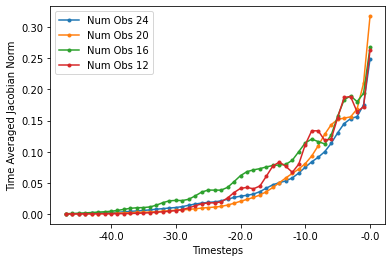

In [ ]:
x = torch.arange(timesteps_jac)
print(x[:].shape)
plt.figure()
for i in [3,2,1,0]:#range(len(models)):
    
    n = torch.mean(torch.norm(grad_xn_xseq[i].cpu(), dim = -1),dim = 1)
    print(i, n.shape)
    inv_n = torch.flip(n,[1])
    inv_x = torch.flip(x,[0])
    plt.plot( inv_n[0,:], ".-", label = f"Num Obs {models[i].num_obs}")
plt.legend()
plt.gca().invert_xaxis()
plt.gca().set_xticklabels([-tick for tick in plt.gca().get_xticks()])
plt.ylabel("Time Averaged Jacobian Norm")
plt.xlabel("Timesteps")

[0.96175534+0.2772779j 0.96175534-0.2772779j]
[0.96173334+0.27727938j 0.96173334-0.27727938j]
[0.9617498+0.27727643j 0.9617498-0.27727643j]
[0.9617698+0.27714092j 0.9617698-0.27714092j]
[0.961787+0.27723852j 0.961787-0.27723852j]
[0.9618397+0.27721834j 0.9618397-0.27721834j]
[0.9617918+0.2772086j 0.9617918-0.2772086j]
[0.96172863+0.27728593j 0.96172863-0.27728593j]


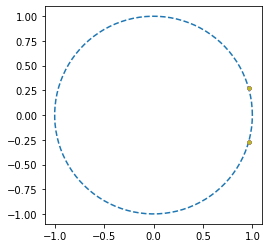

In [34]:
#eigenvalue study
plt.figure()
plt.gca().set_aspect('equal')

angles = np.linspace(0, 2 * np.pi, 100)
unit_circle = np.exp(1j * angles)
plt.plot(unit_circle.real, unit_circle.imag, '--', label = "Unit Circle")

for i in [0,1,2,3,4,5,6,7]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    print(w)
    # plt.matshow(mat)
    # plt.colorbar()
    # plt.figure()
    plt.plot(np.real(w), np.imag(w), ".", label = f"Num Observables {models[i].num_obs}")


# plt.legend()

Text(0.5, 0, '$Img(\\lambda)$')

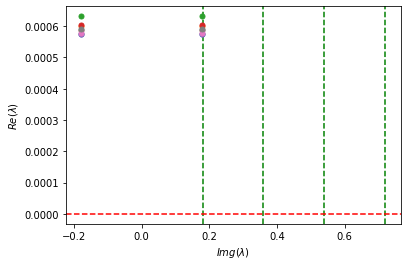

In [36]:
plt.figure()
plt.axvline(0.18, color='green', linestyle='--')
plt.axvline(0.36, color='green', linestyle='--')
plt.axvline(3*0.18, color='green', linestyle='--')
plt.axvline(4*0.18, color='green', linestyle='--')
plt.axhline(0, color='red', linestyle='--')

# plt.text(0.17, 0.075, 'x = 0.17', color='green')
for i in [7,6,5,4,3,2,1,0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.25)/(2*np.pi)
    plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", markersize = 10, label = f"Num Observables {models[i].num_obs}")

plt.ylabel(r"$Re(\lambda)$")
plt.xlabel(r"$Img(\lambda)$")

# plt.ylim(-0.1,0.1)
# plt.xlim(-1,1)
# plt.legend()

<Figure size 432x288 with 0 Axes>

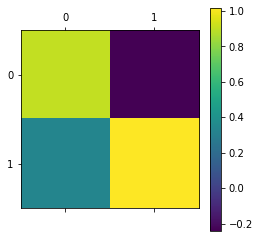

In [121]:
#Matrix
plt.figure()


for i in [0]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    plt.matshow(mat)
    plt.colorbar()
    # plt.figure()
    # plt.plot(np.real(w), np.imag(w), ".", label = f"Num Observables {models[i].num_obs}")

# plt.legend()

In [ ]:
error = np.zeros((1,models[-1].num_obs))
for i in range(error.shape[1]):
    error[0,i] = np.linalg.norm(mat*v[:,i] - w[i]*mat,ord="fro")
print(error)

In [ ]:
#decoding the eigenvectors
print(v.shape)
tv = torch.tensor(np.real(v)).to(models[-2].device)

koopmodes = models[-2].model.autoencoder.recover(tv)
koopmodes.shape

In [ ]:
plt.figure()
plt.scatter(sub_X,sub_Y,c=koopmodes.detach().cpu().numpy()[0,:], s=1, cmap = 'coolwarm')